# Streaming cloud-hosted ICESat-2 ATL15 (Gridded Antarctic/Arctic Land Ice Height) to calculate dh/dt trends
<br>

**Authors**
- Wilson Sauthoff (https://wsauthoff.github.io)
- Matthew Siegfried (https://mrsiegfried.github.io/)

## Key learning outcomes
- Learn how to open, plot, and explore gridded raster data from the ICESat-2 ATL15 data product.
- Use Xarray to import multi-dimensional data stored in "the cloud" and apply a function across a data cube.
- Use gridded time series data to calculate per pixel height change (dh/dt) trends across the full duration of the ICESat-2 mission (2019 to present).

In [1]:
# This tutorial requires a ~32 GB server instance

# Import libraries
import earthaccess
from IPython.display import Image, display
import matplotlib.colors as mpl_colors
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray as xr

## What is ICESat-2?

ICESat-2 (Ice, Cloud, and land Elevation Satellite 2), part of NASA's Earth Observing System, is a satellite mission for measuring ice sheet elevation and sea ice thickness, as well as land topography, vegetation characteristics, and clouds. It does so using an altimeter or an altitude meter, which is an instrument used to measure the altitude of an object above a fixed level (the datum we talked about earlier). This is typically achieved by measuring the time it takes for a lidar or radar pulse, released by a satellite-based altimeter, to travel to a surface, reflect, and return to be recorded by an onboard instrument. ICESat-2 uses three pairs of laser pulsers and the detector to count the reflected photons. 

ICESat-2 laser configuration (from [Smith and others, 2019](https://doi.org/10.1016/j.rse.2019.111352)): 

![ICESat-2 laser configuration](images/Smith_2019_fig1.png)

### What is ATL14/15?
ATL15 is one of the various [ICESat-2 data products](https://icesat-2.gsfc.nasa.gov/science/data-products). ATL15 provides various resolutions (1 km, 10 km, 20 km, and 40 km) of gridded (AKA raster) data of height change at 3-month intervals (Smith and others, 2022), allowing for estimation of dh/dt at each grid cell.

ATL14 is an accompnaying high-resolution (100 m) digital elevation model (DEM) that provides spatially continuous gridded data of ice sheet surface height at a specific datetime. ATL15 height changes are relative to the ATL14 DEM.

Learn more about the ICESat-2 ATL14/15 Gridded Antarctic and Arctic Land Ice Height Change data product dataset [here](https://doi.org/10.5067/ATLAS/ATL15.004).

## Streaming cloud-hosted data from NASA Earthdata Cloud
We will be working with cloud-hosted data files. This [guide](https://nsidc.org/data/user-resources/help-center/nasa-earthdata-cloud-data-access-guide) explains how to find and access Earthdata cloud-hosted data. [Here](https://nsidc.org/data/earthdata-cloud) is a complete list of earthdata cloud-hosted data products currently available from NSIDC.

**Streaming cloud-hosted NASA Earthdata requires a free account. Get one [here](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/earthdata-login).**

In [2]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [3]:
# Find ICESat-2 ATL15 version four data granules in the northern hemisphere
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.004',
    bounding_box=(180, 60, -180, 90),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

In [4]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_SV_0321_40km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_GL_0321_40km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_CS_0321_01km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_SV_0321_10km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_GL_0321_20km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_SV_0321_20km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_RA_0321_20km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_R

In [5]:
# After viewing files, index the files you wish to open
print(files[19])  # 1-km resolution Greenland ATL15

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_GL_0321_01km_004_01.nc>


In [6]:
# Open ATL15 Greenland data granule into an xarray dataset
ATL15_ds = xr.open_dataset(files[19], group='delta_h')

# View file structure and metadata of dataset
ATL15_ds

<xarray.Dataset> Size: 2GB
Dimensions:              (x: 1541, y: 2741, time: 21)
Coordinates:
  * x                    (x) float64 12kB -6.7e+05 -6.69e+05 ... 8.7e+05
  * y                    (y) float64 22kB -3.35e+06 -3.349e+06 ... -6.1e+05
  * time                 (time) datetime64[ns] 168B 2019-01-01T06:00:00 ... 2...
Data variables:
    Polar_Stereographic  int8 1B ...
    ice_area             (time, y, x) float32 355MB ...
    delta_h              (time, y, x) float32 355MB ...
    delta_h_sigma        (time, y, x) float32 355MB ...
    data_count           (time, y, x) float32 355MB ...
    misfit_rms           (time, y, x) float32 355MB ...
    misfit_scaled_rms    (time, y, x) float32 355MB ...
Attributes:
    description:  delta_h group includes variables describing height differen...

## Define functions

In [7]:
def linear_trend(y, time):
    """
    Computes the linear trend (slope) of a time series using linear regression.
    
    Parameters:
    -----------
    y : array-like
        The dependent variable (e.g., data values) for which the trend is to be computed. 
        This is typically a 1D array or list of observations over time.
        
    time : array-like
        The independent variable (e.g., time points). This should be a 1D array of time values 
        corresponding to the `y` values. It is expected that `time` and `y` have the same length.
    
    Returns:
    --------
    slope : float
        The slope of the linear trend. If there is not enough data or all values are NaN, 
        the function returns `np.nan`.
    
    Description:
    ------------
    This function computes the slope of the linear regression line that fits the given data 
    points `(time, y)`. It ignores any `NaN` values in `y` and performs the regression only 
    on valid data points. If there are fewer than two valid data points, the function returns `np.nan`.
    
    Example:
    --------
    >>> y = [2.0, 3.1, 4.2, 5.4, np.nan, 6.8]
    >>> time = [0, 1, 2, 3, 4, 5]
    >>> linear_trend(y, time)
    1.22  # Slope of the linear trend
    
    """
    # Create a mask that is True for finite (non-NaN) values in y, and False for NaN values
    mask = np.isfinite(y)
    
    # If there are fewer than two valid data points, return NaN because we can't fit a line
    if np.sum(mask) < 2:  # Not enough valid data points to compute a trend
        return np.nan
    
    # Perform a linear fit (regression) on the valid data points (ignoring NaNs)
    # np.polyfit returns the slope and intercept, [0] extracts the slope
    return np.polyfit(time[mask], y[mask], 1)[0]  # Return the slope of the fitted line

In [8]:
def plot_timeseries_stat(timeseries_stat_da, cmap_percentile, clb_label, scale_bar_len):
    """
    Plots a timeseries statistic using a diverging colormap and displays a colorbar.
    
    Parameters:
    -----------
    timeseries_stat_da : xarray.DataArray
        The data array containing the timeseries statistic to be plotted.
        
    cmap_percentile : float
        The percentile used to determine the color scale limits. This value 
        is used to control the maximum value in the colormap to avoid extreme outliers.
        
    clb_label : str
        The label for the colorbar. This should describe what the color scale represents.

    scale_bar_len: float
        Length of the displayed scale bar in km.
    
    Returns:
    --------
    None
        Displays a plot of the data with a colorbar.
    
    Description:
    ------------
    This function visualizes a 2D timeseries statistic using a diverging colormap 
    (Red-Blue). It computes the maximum value based on the provided percentile to 
    handle outliers and centers the colormap around zero for balance between 
    positive and negative values. It also adds a horizontal colorbar below the 
    plot, labels it, and hides axis tick marks and labels for a cleaner presentation.
    """
    # Create a figure and axis with a specific size for the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Set the background of the plot area to grey
    ax.set_facecolor('grey')  # This changes the color inside the plot area

    # Customize the border around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # Set border color to black
        spine.set_linewidth(2)        # Set the width of the border to 2 (thicker)

    # Get the minimum and maximum values of the x and y dimensions
    # These values will be used to set the extent of the plot
    x_min = timeseries_stat_da.x.min()
    x_max = timeseries_stat_da.x.max()
    y_min = timeseries_stat_da.y.min()
    y_max = timeseries_stat_da.y.max()

    # Create a diverging normalization for the color scale
    # This centers the color scale at 0, which is useful for visualizing differences
    divnorm = mpl_colors.TwoSlopeNorm(vcenter=0.)

    # Calculate the maximum value based on the provided percentile
    # This ensures that extreme values are captured in the color scale
    v_max = max(np.nanpercentile(timeseries_stat_da, (100 - cmap_percentile)), 
                np.nanpercentile(timeseries_stat_da, cmap_percentile))

    # Create the normalization for the color scale, centered at 0
    norm = mpl_colors.TwoSlopeNorm(vmin=-v_max, vcenter=0, vmax=v_max)

    # Plot the data array using imshow
    # - extent sets the range of the x and y axes
    # - cmap sets the color scheme (RdBu is red to blue for diverging data)
    # - norm applies the normalization we defined above
    # - origin='lower' makes sure the plot is oriented correctly
    m = ax.imshow(timeseries_stat_da, 
                  extent=[x_min, x_max, y_min, y_max],
                  cmap='RdBu', norm=norm,
                  origin='lower')

    # Set the limits for the x and y axes using the min and max values we got earlier
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Remove the tick marks and labels on both the x and y axes to clean up the plot
    ax.tick_params(left=False, right=False, top=False, bottom=False)  # Hide tick marks
    ax.set_xticklabels([])  # Remove labels on the x-axis
    ax.set_yticklabels([])  # Remove labels on the y-axis

    # Add a colorbar below the plot to show the color scale for the data
    # - divider is used to add the colorbar below the plot (bottom) with a specific size and padding
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='2.5%', pad=0.2)
    
    # Add the colorbar to the plot and extend it both ways to indicate out-of-range values
    # - extend='both' adds arrowheads to the colorbar to show that values extend beyond the range
    # - orientation='horizontal' places the colorbar below the plot
    cbar = fig.colorbar(m, cax=cax, extend='both', orientation='horizontal')
    cbar.set_label(clb_label)  # Add a label to the colorbar for clarity

    # Add a label to the colorbar
    cbar.set_label(clb_label, fontsize=16)  # Adjust the fontsize of the colorbar label
    
    # Adjust the fontsize of the colorbar tick labels
    cbar.ax.tick_params(labelsize=14)  # Adjust the fontsize of the colorbar ticks

    # Add a scale bar (e.g., for 100 km)
    scalebar = AnchoredSizeBar(ax.transData,
                               scale_bar_len*1e3,  # Length of the scale bar in km
                               '{} km'.format(scale_bar_len),  # Label for the scale bar
                               loc='lower right',  # Location on the plot
                               pad=0.5,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fm.FontProperties(size=14))  # Font size for the label

    ax.add_artist(scalebar)  # Add the scale bar to the axis

    # Show the plot on the screen
    plt.show()

In [9]:
def fractional_year_rounded(date):
    """
    Converts a given date to a fractional year and rounds it to the nearest 0.25 increment.

    Parameters:
    -----------
    date : numpy.datetime64, pandas.Timestamp, or similar
        The input date to be converted to a fractional year. It can be provided as a 
        numpy datetime64 object or any object convertible to a pandas datetime.
    
    Returns:
    --------
    rounded_fractional_year : float
        The fractional year, rounded to the nearest quarter (0.25) year. The fractional year
        represents the year plus the fraction of the year that has passed based on the day of the year.
    
    Description:
    ------------
    This function calculates the fractional part of the year based on how many days have passed 
    in the year (accounting for leap years if applicable). It then rounds the result to the 
    nearest 0.25 increment, representing the year in quarters.
    
    Example:
    --------
    >>> fractional_year_rounded(np.datetime64('2022-03-15'))
    2022.25
    >>> fractional_year_rounded(pd.Timestamp('2022-11-20'))
    2022.75
    """
    # Convert to pandas datetime to easily extract year and day information
    date = pd.to_datetime(date.astype('datetime64[D]'))
    
    # Get the year and day of year
    year = date.year
    day_of_year = date.dayofyear
    
    # Determine if it's a leap year
    days_in_year = 366 if pd.Timestamp(year, 12, 31).is_leap_year else 365
    
    # Compute the fractional year
    fractional_year = year + (day_of_year / days_in_year)
    
    # Round to the nearest .25 increment
    rounded_fractional_year = np.round(fractional_year * 4) / 4
    
    return rounded_fractional_year

## Greenland Ice Sheet dh/dt

This code will take a few minutes to run.

In [10]:
# Extract the time values from the DataArray's time coordinate
time = ATL15_ds['delta_h']['time'].values

# Convert the time values from datetime64 to a numerical format (e.g., number of days since the first time point)
time_numeric = pd.to_datetime(time)
time_numeric = (time_numeric - time_numeric[0]) / pd.Timedelta(days=365.25)  # Time in years

# Apply the linear trend function over the time dimension
dhdt_trend = xr.apply_ufunc(
    linear_trend,                    # The function to apply
    ATL15_ds['delta_h'],             # The DataArray on which to apply the function
    input_core_dims=[['time']],      # The core dimension for the input (time axis of the DataArray)
    kwargs={'time': time_numeric},   # Pass 'time_numeric' as a keyword argument (numeric time values)
    vectorize=True,                  # Vectorize the function (apply it element-wise)
    dask="parallelized",             # If using Dask for larger datasets
    output_dtypes=[float]            # Output type (trend slope is a float)
)

# Now 'dhdt_trend' contains the dh/dt linear trend for each pixel
# Name dataarray to reflect this
dhdt_trend.name = 'annual_dhdt_trend'

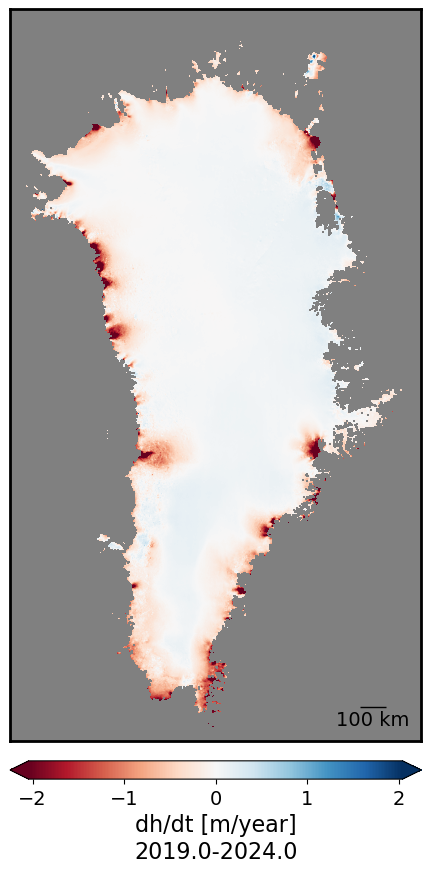

In [11]:
# Get the start and end dates for ATL15 dataset
start_date = ATL15_ds.time[0].values
end_date = ATL15_ds.time[-1].values

# Compute fractional years for both dates
start_fractional_year = fractional_year_rounded(start_date)
end_fractional_year = fractional_year_rounded(end_date)

# Combine the two dates with a hyphen
date_range = f"{start_fractional_year}-{end_fractional_year}"

# Use function to plot dhdt_trend
plot_timeseries_stat(dhdt_trend, 99.99, 'dh/dt [m/year]\n'+date_range, 100)

## Antarctica Ice Sheet ATL15 pre-processing

ATL15 data covering Antarctica requires an additional step of preprocessing because the data are served separately in four quadrants (A1, A2, A3, and A4), which are the cartesian quadrantes in polar stereographic coordinates about the geographic south pole. So in order to make a continental-scale plot of ATL15, we first need to stitch these individual data files together.

(from ATL15 dataset user guide ([Smith and others, 2024](https://doi.org/10.5067/ATLAS/ATL15.004))):
![ICESat-2 ATL15 regions](images/Smith_2024_fig1.png)

In [12]:
# Find ICESat-2 ATL15 version four data granules in the southern hemisphere
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.004',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0321_01km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0321_01km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0321_20km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A4_0321_40km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A4_0321_20km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0321_40km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0321_40km_004_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A

In [13]:
# We first index the data files we wish to open
print(files[11])
print(files[0])
print(files[1])
print(files[-3])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A1_0321_01km_004_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0321_01km_004_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0321_01km_004_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A4_0321_01km_004_01.nc>


In [14]:
# Open each file
ATL15_A1 = xr.open_dataset(files[11], group='delta_h')
ATL15_A2 = xr.open_dataset(files[0], group='delta_h')
ATL15_A3 = xr.open_dataset(files[1], group='delta_h')
ATL15_A4 = xr.open_dataset(files[-3], group='delta_h')

In [15]:
# We will drop unneeded variables to conserve memory

# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [17]:
# Use xarray concatenation to stitch two quadrants together 
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [19]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [20]:
# Use xarray concatenation to stitch two-quadrant concatenated halves togethers
# Use xarray index selecting to occlude the duplicated y=0 vector of data
ATL15_ds = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [22]:
# Delete unneeded dataarrays and datasets to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

### Antarctic Ice Sheet dh/dt

The following code does continental-scale calculations of dh/dt and takes 20-30 minutes to run.

In [23]:
# Extract the time values from the DataArray's time coordinate
time = ATL15_ds['delta_h']['time'].values

# Convert the time values from datetime64 to a numerical format (e.g., number of days since the first time point)
time_numeric = pd.to_datetime(time)
time_numeric = (time_numeric - time_numeric[0]) / pd.Timedelta(days=365.25)  # Time in years

# Apply the linear trend function over the time dimension
dhdt_trend_2 = xr.apply_ufunc(
    linear_trend,                    # The function to apply
    ATL15_ds['delta_h'],             # The DataArray on which to apply the function
    input_core_dims=[['time']],      # The core dimension for the input (time axis of the DataArray)
    kwargs={'time': time_numeric},   # Pass 'time_numeric' as a keyword argument (numeric time values)
    vectorize=True,                  # Vectorize the function (apply it element-wise)
    dask="parallelized",             # If using Dask for larger datasets
    output_dtypes=[float]            # Output type (trend slope is a float)
)

# Now 'dhdt_trend' contains the dh/dt linear trend for each pixel
# Name dataarray to reflect this
dhdt_trend_2.name = 'annual_dhdt_trend'

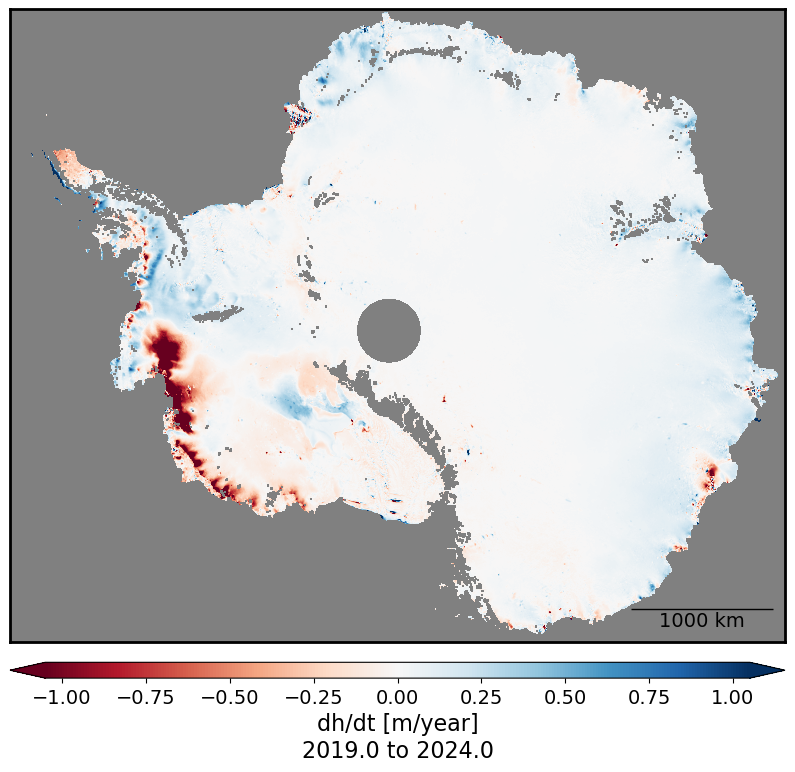

In [24]:
# Get the start and end dates for ATL15 dataset
start_date = ATL15_ds.time[0].values
end_date = ATL15_ds.time[-1].values

# Compute fractional years for both dates
start_fractional_year = fractional_year_rounded(start_date)
end_fractional_year = fractional_year_rounded(end_date)

# Combine the two dates with a hyphen
date_range = f"{start_fractional_year} to {end_fractional_year}"

plot_timeseries_stat(dhdt_trend_2, 99.7, 'dh/dt [m/year]\n'+date_range, 1000)